### Import Libraries

In [1]:
# Importing all required libraries for text preprocessing, feature extraction, model training, and evaluation.  

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP tools

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import warnings
warnings.filterwarnings('ignore')

# Machine Learning models

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Evaluation metrics

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.data.path.append('./nltk_data')

### Load the Dataset

In [2]:
# Loading the BBC News dataset into a DataFrame for analysis. 

data = []
labels = []

base_dir = "bbc"
categories = os.listdir(base_dir)

for category in categories:
    folder_path = os.path.join(base_dir, category)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            with open(os.path.join(folder_path, file_name), 'r', encoding='latin1') as f:
                content = f.read()
                data.append(content)
                labels.append(category)

# Displaying the first few rows to understand the structure of the dataset.  

df = pd.DataFrame({'text': data, 'label': labels})
df

,text,label
0,Musicians to tackle US red tape\n\nMusicians' ...,entertainment
1,"U2's desire to be number one\n\nU2, who have w...",entertainment
2,Rocker Doherty in on-stage fight\n\nRock singe...,entertainment
3,Snicket tops US box office chart\n\nThe film a...,entertainment
4,Ocean's Twelve raids box office\n\nOcean's Twe...,entertainment
...,...,...
2220,Warning over Windows Word files\n\nWriting a M...,tech
2221,Fast lifts rise into record books\n\nTwo high-...,tech
2222,Nintendo adds media playing to DS\n\nNintendo ...,tech
2223,Fast moving phone viruses appear\n\nSecurity f...,tech


### Exploratory Data Analysis  

#### Preprocessing Function

In [3]:
# Defining a function to clean text by removing punctuation, stopwords, and applying lemmatization.  

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
df.head()

,text,label,clean_text
0,Musicians to tackle US red tape\n\nMusicians' ...,entertainment,musician tackle u red tape musician group tack...
1,"U2's desire to be number one\n\nU2, who have w...",entertainment,u desire number one u three prestigious grammy...
2,Rocker Doherty in on-stage fight\n\nRock singe...,entertainment,rocker doherty onstage fight rock singer pete ...
3,Snicket tops US box office chart\n\nThe film a...,entertainment,snicket top u box office chart film adaptation...
4,Ocean's Twelve raids box office\n\nOcean's Twe...,entertainment,ocean twelve raid box office ocean twelve crim...


In [4]:
# Shape of the data
df.shape

(2225, 3)

In [5]:
# Missing values
print(df.isnull().sum())

text          0
label         0
clean_text    0
dtype: int64


In [6]:
empty_texts = df[df['clean_text'].str.strip() == '']
print(f"Empty clean_text entries: {len(empty_texts)}")

Empty clean_text entries: 0


label
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


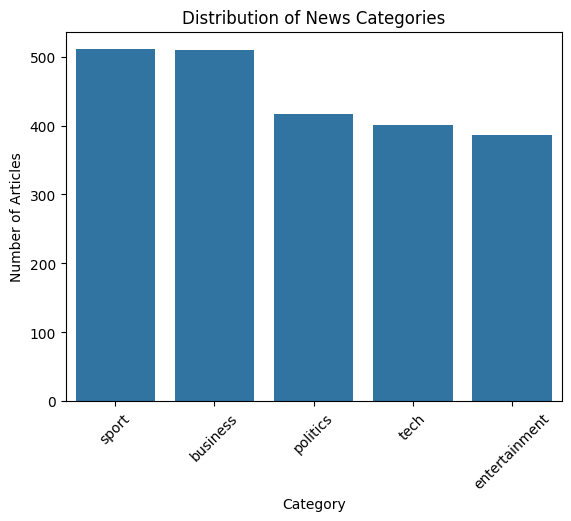

In [7]:
# Bar plot for Distribution of new categories
label_counts = df['label'].value_counts()
print(label_counts)

sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of News Categories")
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()


In [8]:
# Displaying each content for each category after preprocessing
for category in df['label'].unique():
    print(f"\nCategory: {category}")
    print(df[df['label'] == category]['clean_text'].iloc[0][:300], "...")


Category: entertainment
musician tackle u red tape musician group tackle u visa regulation blamed hindering british act chance succeeding across atlantic singer hoping perform u expect pay â£ simply obtaining visa group including musician union calling end raw deal faced british performer u act faced comparable expense bur ...

Category: business
uk economy facing major risk uk manufacturing sector continue face serious challenge next two year british chamber commerce bcc said group quarterly survey company found export picked last three month best level eight year rise came despite exchange rate cited major concern however bcc found whole u ...

Category: sport
fuming robinson blast official england coach andy robinson insisted livid side denied two try sunday six nation loss ireland dublin mark cuetos firsthalf effort ruled offside referee spurned tv replay england crashed dying minute im absolutely spitting im livid there two try weve cost robinson told  ...

Category: politics
bar

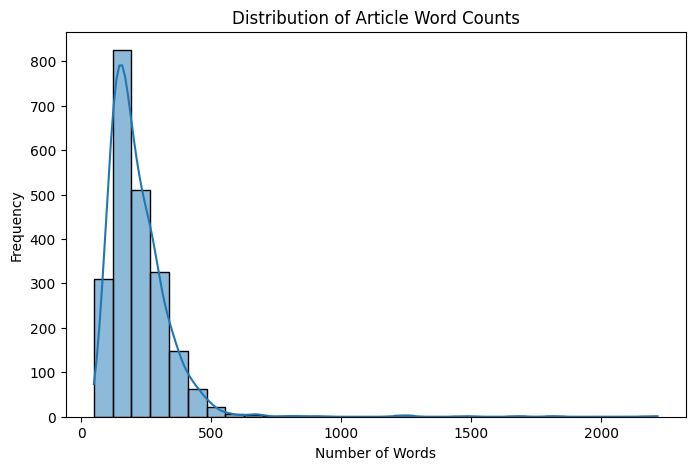

In [9]:
# Histogram for Article Distribution by category
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Distribution of Article Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Statistical description
df['text_length'].describe()

count    2225.000000
mean      217.136629
std       125.858049
min        48.000000
25%       140.000000
50%       190.000000
75%       267.000000
max      2216.000000
Name: text_length, dtype: float64

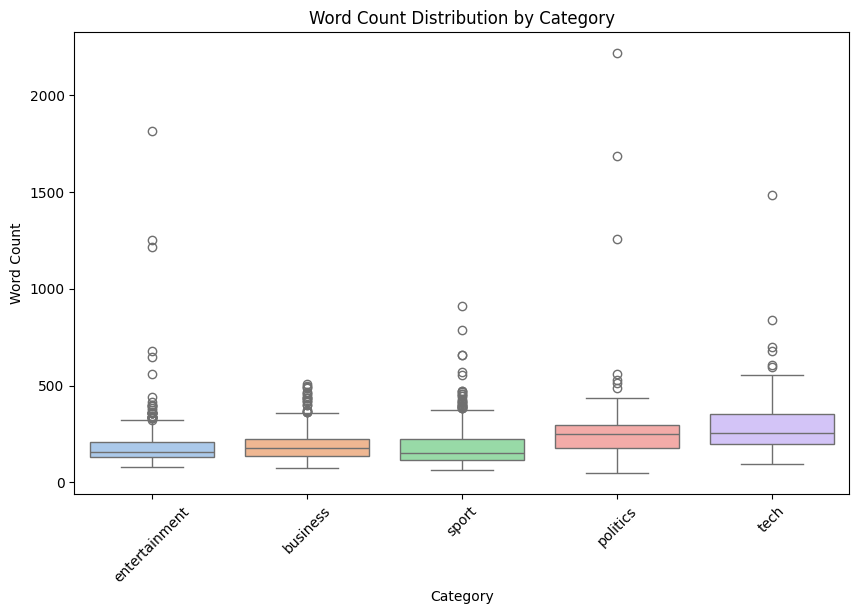

In [11]:
# Box plot for Word count Distribution
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='text_length', data=df, palette='pastel')
plt.title("Word Count Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Word Count")
plt.xticks(rotation=45)
plt.show()

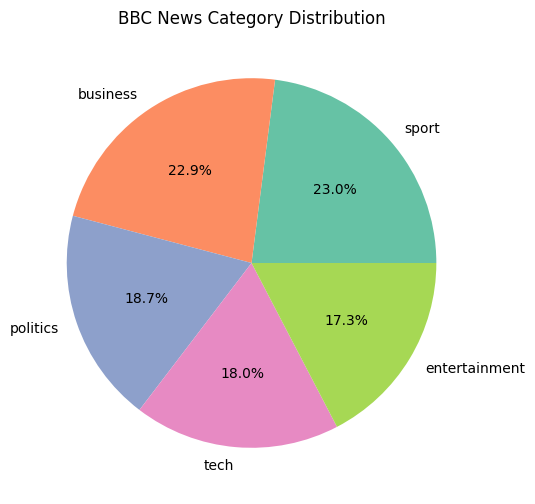

In [12]:
# Pie-chart for Category Distribution
plt.figure(figsize=(6,6))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title("BBC News Category Distribution")
plt.ylabel("")
plt.show()

### Feature Extraction (TF-IDF)

In [13]:
# Converting cleaned text into numerical vectors using TF-IDF representation.  
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['clean_text'])  
y = df['label']

### Train-Test Split  

In [14]:
# Splitting the dataset into training and test sets for model evaluation.  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (1780, 5000)
Test size: (445, 5000)


### Logistic Regression Model

In [15]:
# Training and evaluating Logistic Regression on the TF-IDF features.  

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')

logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

Classification Report:

               precision    recall  f1-score   support

     business       0.98      0.97      0.98       103
entertainment       1.00      0.96      0.98        84
     politics       0.95      0.99      0.97        80
        sport       1.00      0.99      0.99        98
         tech       0.98      1.00      0.99        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



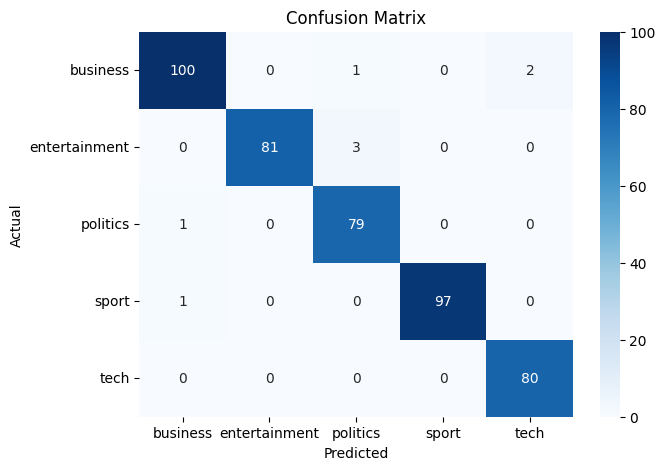

In [16]:
# Classification report and Confusion matrix for Logistic Regression
y_pred = logreg.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Support Vector Machine (SVM)  

In [17]:
# Training and evaluating Support Vector Machine (LinearSVC) for classification.  

svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

SVM (LinearSVC) Classification Report:

               precision    recall  f1-score   support

     business       0.98      0.96      0.97       103
entertainment       0.99      0.99      0.99        84
     politics       0.96      0.99      0.98        80
        sport       1.00      0.99      0.99        98
         tech       0.99      1.00      0.99        80

     accuracy                           0.98       445
    macro avg       0.98      0.99      0.98       445
 weighted avg       0.98      0.98      0.98       445



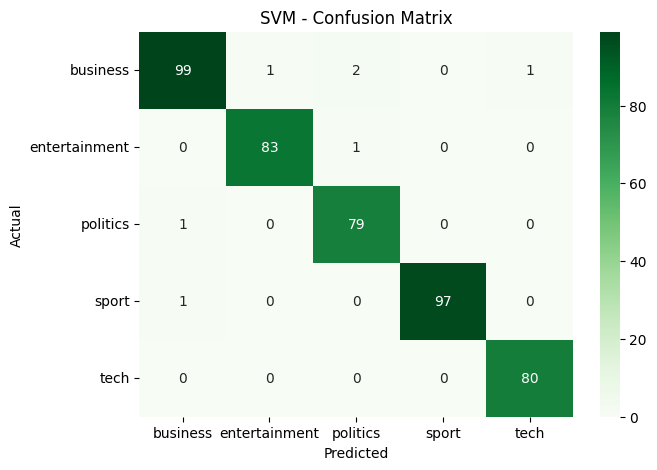

In [18]:
# Classification report and Confusion matrix for Support Vector Machine (LinearSVC)

y_pred_svm = svm_model.predict(X_test)

print("SVM (LinearSVC) Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(7,5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Naive Bayes Model

Naive Bayes Report:
               precision    recall  f1-score   support

     business       0.96      0.98      0.97       103
entertainment       1.00      0.96      0.98        84
     politics       0.92      0.97      0.95        80
        sport       0.99      0.99      0.99        98
         tech       0.99      0.94      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



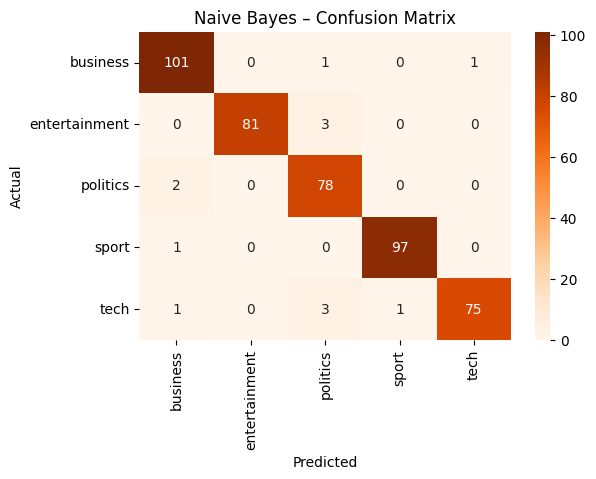

In [19]:
# Training and evaluating Naive Bayes classifier for text classification.  

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Classification report and Confusion matrix for Naive Bayes classifier

print("Naive Bayes Report:")
print(classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title("Naive Bayes – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Random Forest Model

Random Forest Report:
               precision    recall  f1-score   support

     business       0.96      0.94      0.95       103
entertainment       1.00      0.98      0.99        84
     politics       0.94      0.99      0.96        80
        sport       0.99      1.00      0.99        98
         tech       0.96      0.95      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



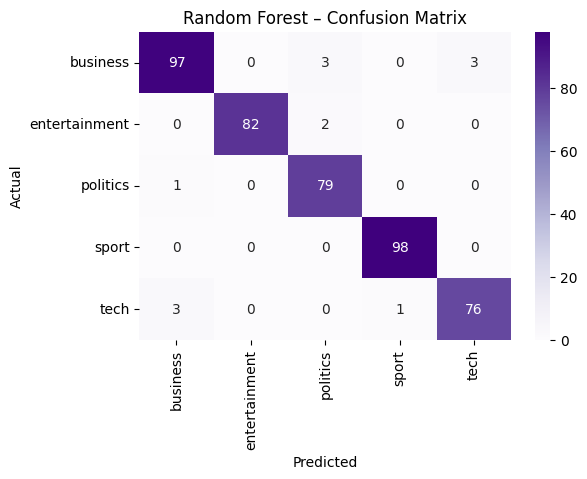

In [20]:
# Training and evaluating Random Forest classifier for text classification.  

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Classification report and Confusion matrix for Random Forest classifier

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Model Comparison 

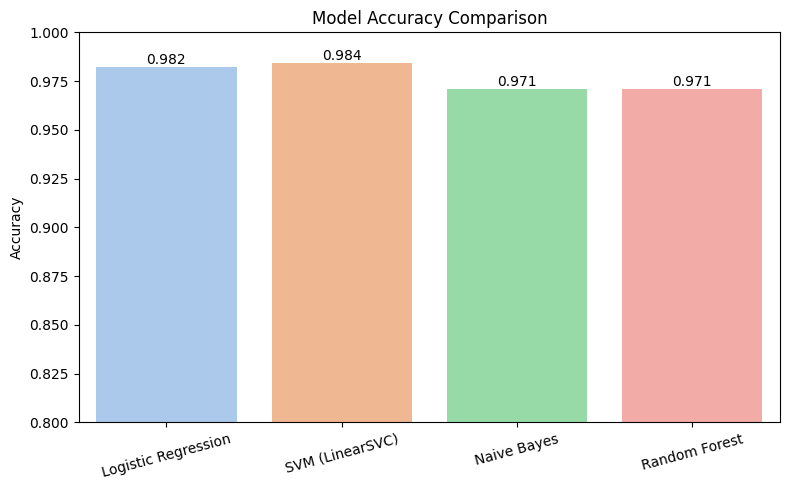

In [21]:
# Comparing the accuracy scores of all trained models using a bar chart.  

model_scores = {
    "Logistic Regression": accuracy_score(y_test, y_pred),
    "SVM (LinearSVC)": accuracy_score(y_test, y_pred_svm),
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
}

# Bar chart comparison
plt.figure(figsize=(8,5))
ax = sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette='pastel')
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.title("Model Accuracy Comparison")
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Model Optimization (Hyperparameter Tuning)

In [22]:
# Using GridSearchCV to tune Logistic Regression hyperparameters such as C, solver, and class weight to improve performance.  

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced', None]
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

y_pred_grid = grid.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_grid))

Best Parameters: {'C': 1, 'class_weight': None, 'solver': 'liblinear'}
Best CV Accuracy: 0.9735955056179775
Test Accuracy: 0.9730337078651685
